In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar, brute, dual_annealing
import pygad
from importlib import reload
from IPython.display import clear_output

import tgs 
import rgs 

reload(tgs)
reload(rgs)

<module 'rgs' from '/Users/gordonwongyl/Documents/ORF/Reproduce_result/rgs.py'>

In [6]:
L_ATT = 20e3
def negative_key_rate_given_m(m, *params):
    L, time, L_delay, T_SPIN_COH, b0, b1, b2 = params
    miu = tgs.Miu(L, L_ATT, L_delay=L_delay, m=m)
    tree = tgs.Tree_ancilla(np.array([b0, b1, b2]), miu=miu)
    error = tgs.Error(tree, time, t_spin_coherence=T_SPIN_COH)
    result = -tgs.effective_key_rate(tree, time, error, m, 2)
    if result > 0.:
        return 0.
    return result
    
def tgs_negative_keyrate_given_branch(BRANCH_PARAM, *params):
    params = params + tuple(BRANCH_PARAM)
    # print(params)
    res_high = minimize_scalar(negative_key_rate_given_m, bounds=(100., 1000.), args=params, method="Bounded")
    res_i = res_high
    if res_high.fun > -1.:
        res_low = minimize_scalar(negative_key_rate_given_m, bounds=(1., 100.), args=params, method="Bounded")
        if res_low.fun < res_high.fun:
            res_i = res_low
    return res_i.fun
    ...



In [7]:
GAMMA = np.array([2e9, 100e9, 170e6, 100e9]) * 2 * np.pi
T_SPIN_COHERENCE = [13e-3, 4e-6, 1., 1.]
BRANCH_PARAM = [np.array([4,16,5]), np.array([1,1,19]), np.array([4,18,5]), np.array([4,16,5])]

for i in range(4):
    res = []
    time = tgs.Time(GAMMA[i])
    params = 1000e3, time, 0., T_SPIN_COHERENCE[i], BRANCH_PARAM[i][0], BRANCH_PARAM[i][1], BRANCH_PARAM[i][2]
    # print(params)
    res_high = minimize_scalar(negative_key_rate_given_m, bounds=(100., 1000.), args=params, method="Bounded")
    res_i = res_high
    if res_high.fun > -1.:
        res_low = minimize_scalar(negative_key_rate_given_m, bounds=(1., 100.), args=params, method="Bounded")
        if res_low.fun < res_high.fun:
            res_i = res_low

    # res_i = dual_annealing(negative_key_rate_given_m, bounds=[(10., 700.)], args=params, x0=[500.])
    res.append(res_i)
    print(res_i.fun)



-2798.648526232008512
-4.089531369539565422e-17


/Users/gordonwongyl/Documents/ORF/Reproduce_result/tgs.py:319: RuntimeWarning: invalid value encountered in log2
  return  - x*np.log2(x) - (1-x)*np.log2(1-x)


-922.74324175979635293
-3544.8641127222266765


In [8]:
BRANCH_ranges = (slice(4, 5, 1), slice(1, 20, 1), slice(1, 6, 1))
for i in range (4):
    res = []
    time = tgs.Time(GAMMA[i])
    params = 1000e3, time, 0., T_SPIN_COHERENCE[i]
    resbrute = brute(tgs_negative_keyrate_given_branch, BRANCH_ranges, args=params, full_output=True, finish=None)
    res.append(resbrute)
    print(resbrute[0])

KeyboardInterrupt: 

In [9]:
def tgs_positive_keyrate_given_branch(BRANCH_PARAM, *params):
    params = params + tuple(BRANCH_PARAM)
    res_high = minimize_scalar(negative_key_rate_given_m, bounds=(1., 1000.), args=params, method="Bounded")
    res_i = res_high
    if res_high.fun > -1.:
        res_low = minimize_scalar(negative_key_rate_given_m, bounds=(1., 100.), args=params, method="Bounded")
        if res_low.fun < res_high.fun:
            res_i = res_low
    return float(-res_i.fun)


PARAMS = 1000e3, tgs.Time(GAMMA[0]), 0., T_SPIN_COHERENCE[0]
def fitness_func(ga_instance, solution, solution_idx):
    value = tgs_positive_keyrate_given_branch(solution, *PARAMS)
    value = np.nan_to_num(value)
    # print(solution[0], solution[1], solution[2], value)
    return value

def diversity(ga_instance, K=4):
     index_k_best_list = sorted(range(ga_instance.pop_size[0]), key = lambda sub: ga_instance.last_generation_fitness[sub])[-K:]
     worst_solution = ga_instance.population[index_k_best_list[0]][:-1] # compare the branch paramaters
     best_solution = ga_instance.population[index_k_best_list[-1]][:-1]

     sum_diff = np.sum(np.abs(best_solution-worst_solution))
     return sum_diff

def on_gen(ga_instance):
    if int(ga_instance.generations_completed) % 2 == 0:
        clear_output(wait=True)

    print("Generation : ", ga_instance.generations_completed, flush=True)
    print("Fitness of the best solution :", ga_instance.best_solution()[0])


num_generations = 10
num_parents_mating = 4

fitness_function = fitness_func

sol_per_pop = 10 # number of solutions within the population
num_genes = 3 # the function inputs
gene_type = int # input type
gene_space = range(21) # specify the possible values for each gene

init_range_low = 1
init_range_high = 10

parent_selection_type = "sss"
keep_parents = -1 # Number of parents to keep in the current population
keep_elitism = 1 # only the best solution in the current generation is kept in the next generation.

crossover_type = "single_point" 

mutation_type = "random"

mutation_percent_genes = 10.

In [10]:
def key_rate_unpack(solution, *params):
    b0, b1, b2, m = solution
    L, time, L_delay, T_SPIN_COH = params
    miu = tgs.Miu(L, L_ATT, L_delay=L_delay, m=m)
    tree = tgs.Tree_ancilla(np.array([b0, b1, b2]), miu=miu)
    error = tgs.Error(tree, time, t_spin_coherence=T_SPIN_COH)
    result = tgs.effective_key_rate(tree, time, error, m, 2)
    if result < 0. :
        return 0.
    return float(np.nan_to_num(result))

def fitness_func_with_m(ga_instance, solution, solution_idx):
    return key_rate_unpack(solution, *PARAMS)

def tgs_optimized_key_rate_wrt_m(branch_param, m0, *params):
    params = params + tuple(branch_param)
    res = minimize_scalar(negative_key_rate_given_m, bounds=(max(m0-500, 0.), min(m0+500, 2000.)), args=params, method="Bounded")
    return float(-res.fun), res.x

def on_fitness(ga_instance, population_fitness):
    # find indices of k_best population_fitness solutions
    K=4

    index_k_best_list = sorted(range(ga_instance.pop_size[0]), key = lambda sub: population_fitness[sub])[-K:]
    div = diversity(ga_instance, K)

    if ga_instance.generations_completed > 10 or div<=2: 
        for i in index_k_best_list:
            # Refine the key rates and m for these good candidates
            branch_param = ga_instance.population[i][:-1]
            m = ga_instance.population[i][-1]
            print(f"Branch paramaters: {branch_param}")
            print(f"Before: m={m}, fitness={ga_instance.last_generation_fitness[i]}")
            ga_instance.last_generation_fitness[i], ga_instance.population[i][-1] = tgs_optimized_key_rate_wrt_m(branch_param, m, *PARAMS)
            m = ga_instance.population[i][-1]
            print(f"After:  m={m}, fitness={ga_instance.last_generation_fitness[i]}")
    
    div = diversity(ga_instance, K)
    print(f"Diversity of this generation: {div}")
    if div == 0 and ga_instance.mutation_percent_genes <= 40.:
        ga_instance.mutation_percent_genes += 1.5
    if div >= 2 and ga_instance.generations_completed > 5:
        ga_instance.mutation_percent_genes -= 2.
    print("Mutation_percent_genes for this generation = ", ga_instance.mutation_percent_genes)

        # Update m and the corresponding fitness
        
    ...

num_generations = 20
num_parents_mating = 8

fitness_function = fitness_func_with_m

sol_per_pop = 80 # number of solutions within the population (initially)
num_genes = 4 # the function inputs
gene_type = [int, int, int, float] # input type
gene_space = [range(1, 11), range(1, 30), range(1, 30), {"low": 1., "high": 2000.}]  # specify the possible values for each gene

init_range_low = 1
init_range_high = 10

parent_selection_type = "sss"
keep_parents = -1 # Number of parents to keep in the current population
keep_elitism = 1 # only the best solution in the current generation is kept in the next generation.

crossover_type = "single_point" 

mutation_type = "random"

mutation_percent_genes = 25.

parallel_processing = ["process", 0]

In [11]:
ga_instance = pygad.GA(num_generations=num_generations,
                        num_parents_mating=num_parents_mating,
                        fitness_func=fitness_function,
                        sol_per_pop=sol_per_pop,
                        num_genes=num_genes,
                        gene_type=gene_type,
                        gene_space=gene_space,
                        init_range_low=init_range_low,
                        init_range_high=init_range_high,
                        parent_selection_type=parent_selection_type,
                        keep_parents=keep_parents,
                        keep_elitism=keep_elitism,
                        crossover_type=crossover_type,
                        mutation_type=mutation_type,
                        mutation_percent_genes=mutation_percent_genes, 
                        
                        on_generation=on_gen, on_fitness=on_fitness, parallel_processing=parallel_processing, save_solutions=True, stop_criteria="saturate_5")

ga_instance.run()

Generation :  2


KeyboardInterrupt: 

No handles with labels found to put in legend.


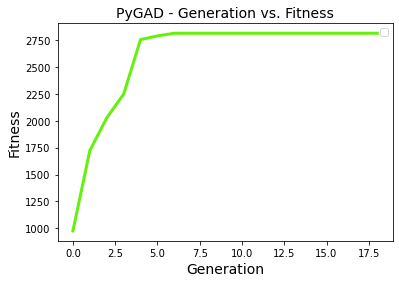

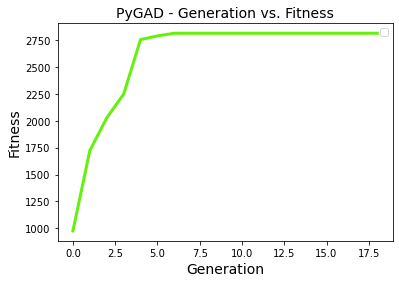

In [ ]:
ga_instance.plot_fitness()

In [ ]:
params = (1, 1, 1)
def test_func(solution):
    return float(solution[0]*params[0] + solution[1]*params[1] + solution[2]*params[2])

params = (1, -5, 1)
test_func([1,2,1])

-8.0